In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [131]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mounted at /content/drive
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-131-cf53a7d14625>", line 3, in <module>
    get_ipython().magic('cd "/content/drive/My Drive/automatic-asset-classification"')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transpo

OSError: ignored

# Autoencoder 1

## Data

In [0]:
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32
tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

## Model

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

In [19]:
autoencoder = AutoEncoder();

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


## Training

In [0]:
learn = Learner(data, autoencoder, loss_func=F.mse_loss);

In [8]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.188093,#na#,01:40
1,0.188188,#na#,00:17
2,0.183170,#na#,00:17
3,0.157658,#na#,00:17
4,0.129074,#na#,00:17
5,0.116742,#na#,00:17
6,0.150142,#na#,00:17
7,0.181498,#na#,00:17


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 5.75E-03


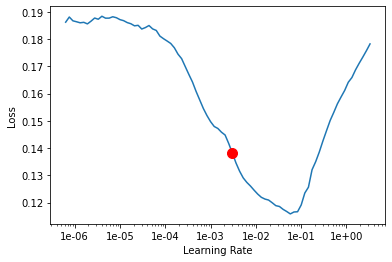

In [9]:
learn.recorder.plot(suggestion = True)

In [10]:
learn.fit_one_cycle(100, max_lr = 1.5e-02)

epoch,train_loss,valid_loss,time
0,0.091474,0.057105,00:46
1,0.055398,0.022121,00:21
2,0.039571,0.021813,00:21
3,0.031859,0.014531,00:21
4,0.025503,0.007981,00:21
5,0.020788,0.008161,00:21
6,0.017290,0.005730,00:22
7,0.014522,0.004819,00:21
8,0.012267,0.008577,00:21
9,0.010672,0.005099,00:21


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn.save('ae_res_1')

## Results

In [0]:
learn = learn.load('ae_res_1')

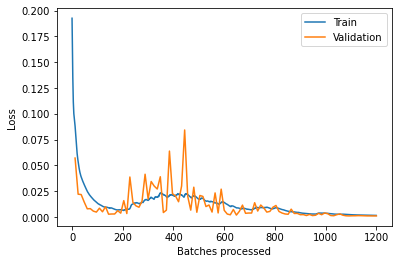

In [13]:
learn.recorder.plot_losses()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


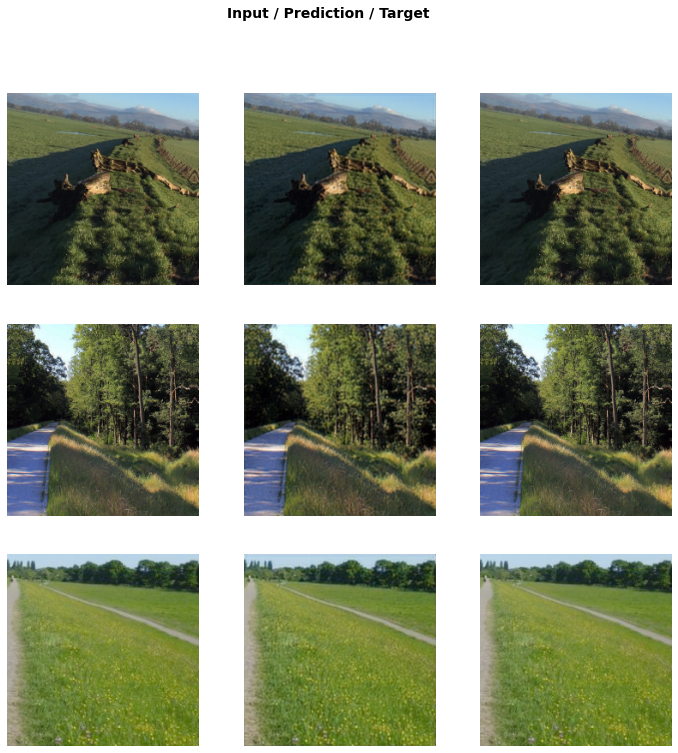

In [14]:
learn.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


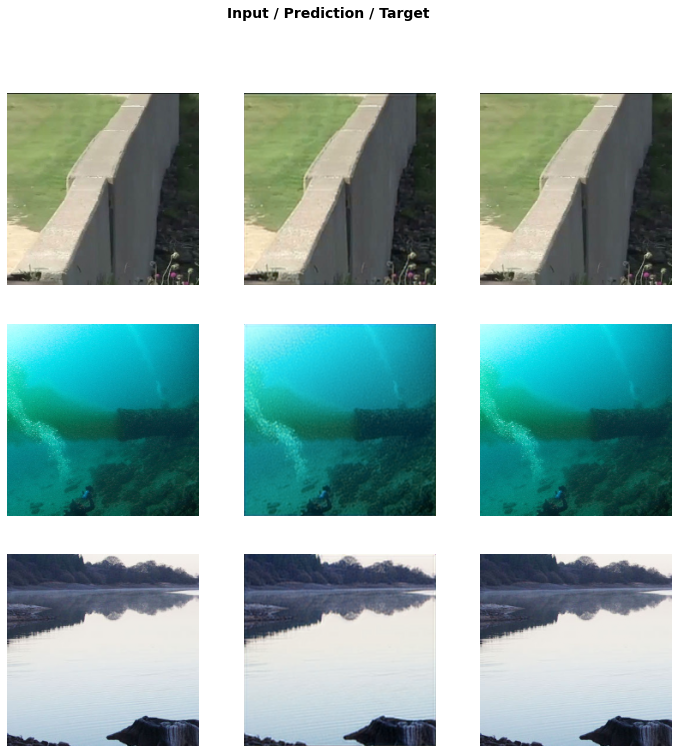

In [15]:
learn.show_results(ds_type=DatasetType.Valid, rows =3)

# AutoEncoder 2

## Data

In [0]:
train_batches = [item[0] for item in iter(data.train_dl)]
valid_batches = [item[0] for item in iter(data.valid_dl)]

In [0]:
autoencoder.eval()
autoencoder.cuda()
encoded_train_batches = [];
encoded_valid_batches = [];

with torch.no_grad():

  for train in train_batches:
    encoded_train = autoencoder.encode(train);
    encoded_train_batches.append(encoded_train);
  
  for valid in valid_batches:
    encoded_valid = autoencoder.encode(valid);
    encoded_valid_batches.append(encoded_valid);

In [32]:
encoded_train_batches = np.concatenate([batch.cpu().numpy() for batch in encoded_train_batches])
encoded_valid_batches = np.concatenate([batch.cpu().numpy() for batch in encoded_valid_batches])
print(encoded_train_batches.shape, encoded_valid_batches.shape)

(384, 64, 112, 112) (96, 64, 112, 112)


In [0]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = ArrayDataset(encoded_train_batches, encoded_train_batches), ArrayDataset(encoded_valid_batches, encoded_valid_batches)

In [0]:
data2 = DataBunch.create(train_ds, valid_ds, bs=32)

## Model

In [0]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

## Training

In [96]:
autoencoder2 = AutoEncoder2()
learn2 = Learner(data2, autoencoder2, loss_func = F.mse_loss)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [98]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.093638,0.074193,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [99]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.072114,#na#,00:02
1,0.071999,#na#,00:02
2,0.071267,#na#,00:02
3,0.071450,#na#,00:02
4,0.070250,#na#,00:02
5,0.073073,#na#,00:02
6,0.084759,#na#,00:02
7,0.099310,#na#,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-04


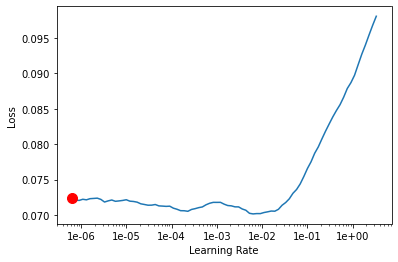

In [100]:
learn2.recorder.plot(suggestion = True)

In [101]:
learn2.fit_one_cycle(100, max_lr = 1e-04)

epoch,train_loss,valid_loss,time
0,0.071951,0.073992,00:02
1,0.071554,0.073232,00:02
2,0.071120,0.072399,00:02
3,0.070603,0.071511,00:02
4,0.070067,0.070741,00:02
5,0.069536,0.070168,00:02
6,0.069050,0.069789,00:02
7,0.068647,0.069323,00:02
8,0.068220,0.068790,00:02
9,0.067764,0.068155,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
learn2.save('ae_res_2')

## Results

In [0]:
learn2 = learn2.load('ae_res_2')

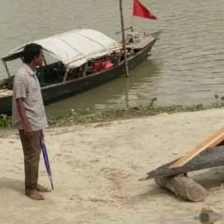

In [105]:
img = data.train_ds[0][0]
img

In [0]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

Original autoencoder prediction:

In [0]:
learn = learn.load('ae_res_1')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


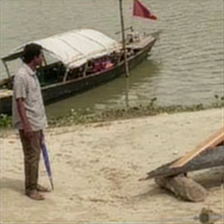

In [127]:
autoencoder.eval()
with torch.no_grad():
  pred = learn.model(example.unsqueeze_(0).cuda())

Image(pred.squeeze(0).cpu())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


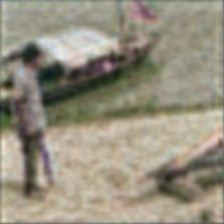

In [128]:
example = img.data
example = (example - torch.Tensor([0.485,0.456,0.406])[...,None,None])/torch.Tensor([0.229, 0.224, 0.225])[...,None,None]

autoencoder.eval()
autoencoder2.eval()
with torch.no_grad():
  pred = learn.model.encode(example.unsqueeze_(0).cuda())
  pred = autoencoder2(pred)
  pred = learn.model.decode(pred)

Image(pred.squeeze(0).cpu())

In [91]:
resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
resnet = nn.Sequential(*(list(resnet.children())))
(resnet[3:5](torch.randn([32, 64, 112, 112]))).shape

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


torch.Size([32, 64, 56, 56])